## IMPORTS

In [1]:
!pip install datasets transformers
!pip install scikit-multilearn
!pip install accelerate -U
!pip install tensorflow
!pip install keras
!pip install nltk
!pip install torch
!pip3 install nvidia-tensorrt

  Obtaining dependency information for accelerate from https://files.pythonhosted.org/packages/d9/92/2d3aecf9f4a192968035880be3e2fc8b48d541c7128f7c936f430d6f96da/accelerate-0.23.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [2]:
import pickle
import pandas as pd
import numpy as np
import nltk
import torch
import string
import os
import tensorflow as tf
import time
import transformers
from time import sleep
from string import punctuation
from sklearn import metrics
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, TFBertModel
from datasets import load_dataset, load_from_disk, DatasetDict, Dataset
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.regularizers import l2
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image, UnidentifiedImageError

2023-09-18 15:11:04.919548: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-18 15:11:07.936986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jessica/.pyenv/versions/3.10.6/envs/movie_genre_prediction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## LOADING DATASET

In [28]:
# webscraping from imdb for 3000 movies from each genre and after dropping duplicates

big_data = pd.read_csv('big_data.csv').drop(columns = 'Unnamed: 0')

In [17]:
big_data.head()

,imdb_id,genre,plot
0,tt1517268,"['Adventure', 'Comedy', 'Fantasy']",barbie suffers a crisis that leads her to ques...
1,tt6791350,"['Action', 'Adventure', 'Comedy']",still reeling from the loss of gamora peter qu...
2,tt9224104,"['Action', 'Adventure', 'Horror']",a research team encounters multiple threats wh...
3,tt8589698,"['Animation', 'Action', 'Adventure']",the film follows the turtle brothers as they w...
4,tt9362722,"['Animation', 'Action', 'Adventure']",miles morales catapults across the multiverse ...


In [29]:
big_data["genre"] = (
    big_data["genre"]
    .apply(eval)
    .apply(lambda x: [genre.strip() for genre in x])
    )

In [30]:
# distribution of genres within dataset (very imbalanced)

big_data['genre'].explode().value_counts()

Drama         16371
Comedy         9340
Action         6113
Adventure      5266
Romance        4810
Crime          4112
Horror         3781
Thriller       3401
Biography      2973
Animation      2908
Family         2821
Mystery        2613
Music          2593
History        2540
Fantasy        2495
Musical        2285
Sci-Fi         2085
Sport          2078
War            1877
Western         290
Film-Noir       190
Reality-TV        2
News              1
Name: genre, dtype: int64

<Axes: >

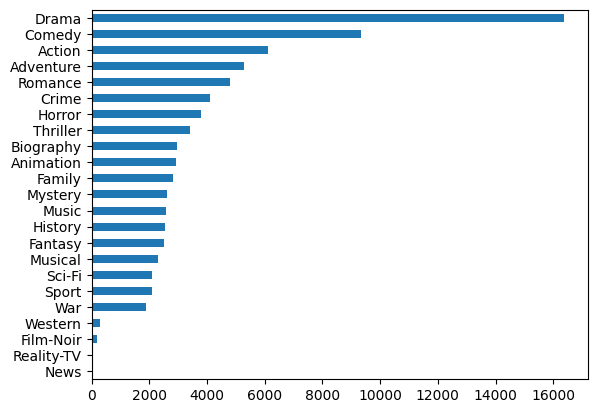

In [31]:
# plotting distribution of genres within dataset

big_data.genre.explode().value_counts().sort_values().plot(kind = 'barh')

## BALANCING DATASET

In [32]:
# attempt to balance dataset by removing genres with very high and very low counts

big_data["genre"] = (
    big_data["genre"]
    .apply(lambda x: [genre for genre in x if genre != 'Drama'])
    .apply(lambda x: [genre for genre in x if genre != 'Reality-TV'])
    .apply(lambda x: [genre for genre in x if genre != 'News'])
    .apply(lambda x: [genre for genre in x if genre != 'Film-Noir'])
    .apply(lambda x: [genre for genre in x if genre != 'Biography'])
    .apply(lambda x: [genre for genre in x if genre != 'Musical'])
    .apply(lambda x: [genre for genre in x if genre != 'Music'])
    .apply(lambda x: [genre for genre in x if genre != 'Family'])
    .apply(lambda x: [genre for genre in x if genre != 'Western'])
    .apply(lambda x: [genre for genre in x if genre != 'Sport'])
    .apply(lambda x: [genre for genre in x if genre != 'Sci-Fi'])
    .apply(lambda x: [genre for genre in x if genre != 'Fantasy'])
    .apply(lambda x: [genre for genre in x if genre != 'History'])
    .apply(lambda x: [genre for genre in x if genre != 'Mystery'])
    )

In [37]:
# remove movies which no longer have an assigned genre or are purely comedy or action (still slightly higher count than other genres)
empty_list = []

for index,row in big_data.iterrows():
    if row['genre'] == [] or row['genre'] == ['Comedy'] or row['genre'] == ['Action']:
        empty_list.append(row['imdb_id'])

big_data = big_data.loc[~big_data['imdb_id'].isin(empty_list)]
big_data = big_data.reset_index(drop = True)

In [36]:
# checking distribution of genres in new dataset, now it is more balanced

big_data['genre'].explode().value_counts()

Comedy       5716
Adventure    5266
Action       5201
Romance      4810
Crime        4112
Horror       3781
Thriller     3401
Animation    2908
War          1877
Name: genre, dtype: int64

In [ ]:
# removing movies from dataset with corrupted posters

corrupted_posters = []

for index, row in tqdm(big_data.iterrows(), total=big_data.shape[0]):
    try:
        images_path = f"/home/jessica/code/chooj202/movie_genre_prediction/notebooks/combined folder/{row['imdb_id']}.jpg"
        image = Image.open(images_path)
    except:
        corrupted_posters.append(row['imdb_id'])

big_data = big_data[~big_data['imdb_id'].isin(corrupted_posters)]
big_data = big_data.reset_index(drop = True)

## TEXT PREPROCESSING

In [ ]:
# cleaning movie plots 

def cleaning(sentence):

    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers

    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation

    return sentence

In [ ]:
big_data['plot'] = big_data['plot'].apply(cleaning)

## SPLITTING DATASET

In [ ]:
# function to have more balanced split of genres as it is a multilabel dataset

from skmultilearn.model_selection import iterative_train_test_split

mlb = MultiLabelBinarizer()

def balanced_split(df, mlb, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    mlb.fit_transform(df["Genre"])
    labels = mlb.transform(df["Genre"])
    ind_train, _, ind_test, _ = iterative_train_test_split(
        ind, labels, test_size
    )
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [ ]:
df_train, df_test = balanced_split(big_data, mlb, test_size=0.2)

In [ ]:
df_val, df_test = balanced_split(df_test, mlb, test_size=0.5)

## IMAGE PREPROCESSING

In [ ]:
# converting train dataset to array

width, height = 256, 256
image_array = []
unidentified_count = 0
not_found_count = 0
for i in tqdm(range(df_train.shape[0])):
    try:
        image_path = f"/home/jessica/code/chooj202/movie_genre_prediction/notebooks/combined folder/{df_train['imdb_id'][i]}.jpg"
        img = image.load_img(image_path, target_size=(width, height, 3))
        input_arr = image.img_to_array(img)
        image_array.append(input_arr)
    except UnidentifiedImageError as e1:
        unidentified_count += 1
        pass
    except FileNotFoundError as e2:
        not_found_count += 1
        pass
        
print(f"{unidentified_count} files were unidentified and {not_found_count} files were not found")
train_imgs = np.array(image_array)

In [ ]:
# converting test dataset to array

width, height = 256, 256
image_array = []
unidentified_count = 0
not_found_count = 0
for i in tqdm(range(df_test.shape[0])):
    try:
        image_path = f"/home/jessica/code/chooj202/movie_genre_prediction/notebooks/combined folder/{df_test['imdb_id'][i]}.jpg"
        img = image.load_img(image_path, target_size=(width, height, 3))
        input_arr = image.img_to_array(img)
        image_array.append(input_arr)
    except UnidentifiedImageError as e1:
        unidentified_count += 1
        pass
    except FileNotFoundError as e2:
        not_found_count += 1
        pass
        
print(f"{unidentified_count} files were unidentified and {not_found_count} files were not found")
test_imgs = np.array(image_array)

In [ ]:
# converting val dataset to array

width, height = 256, 256
image_array = []
unidentified_count = 0
not_found_count = 0
for i in tqdm(range(df_val.shape[0])):
    try:
        image_path = f"/home/jessica/code/chooj202/movie_genre_prediction/notebooks/combined folder/{df_val['imdb_id'][i]}.jpg"
        img = image.load_img(image_path, target_size=(width, height, 3))
        input_arr = image.img_to_array(img)
        image_array.append(input_arr)
    except UnidentifiedImageError as e1:
        unidentified_count += 1
        pass
    except FileNotFoundError as e2:
        not_found_count += 1
        pass
        
print(f"{unidentified_count} files were unidentified and {not_found_count} files were not found")
val_imgs = np.array(image_array)

## GENRE ENCODING

In [42]:
# transform multi-label genre column into a binary matrix for multi-label classification
# train dataset

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_train['genre'])

#transform target variable
y_train = multilabel_binarizer.transform(df_train['genre'])
genre_names = multilabel_binarizer.classes_

# Adding
for i in range(len(genre_names)):
    df_train[f"{genre_names[i]}"] = y_train[:,i]

In [43]:
# test dataset

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_test['genre'])

#transform target variable
y_test = multilabel_binarizer.transform(df_test['genre'])
genre_names = multilabel_binarizer.classes_

# Adding
for i in range(len(genre_names)):
    df_test[f"{genre_names[i]}"] = y_test[:,i]

In [44]:
# val dataset

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(df_val['genre'])

#transform target variable
y_val = multilabel_binarizer.transform(df_val['genre'])
genre_names = multilabel_binarizer.classes_

# Adding
for i in range(len(genre_names)):
    df_val[f"{genre_names[i]}"] = y_val[:,i]

In [ ]:
genre_names

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Horror', 'Romance', 'Thriller', 'War'], dtype=object)

## TOKENIZING TEXT

In [45]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_text = df_train['plot'].to_list()

In [46]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

test_text = df_test['plot'].to_list()

In [47]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

val_text = df_val['plot'].to_list()

In [48]:
train_encodings = tokenizer(train_text, truncation = True, padding = True, max_length = 128, return_tensors = "np")
test_encodings = tokenizer(test_text, truncation = True, padding = True, max_length = 128, return_tensors = "np")
val_encodings = tokenizer(val_text, truncation = True, padding = True, max_length = 128, return_tensors = "np")

## RESNET PREPROCESSING IMAGE ARRAYS

In [49]:
train_imgs = preprocess_input(train_imgs)
val_imgs = preprocess_input(val_imgs)
test_imgs = preprocess_input(test_imgs)

In [50]:
# defining variables 

X_train_img = train_imgs
X_train_text = train_encodings['input_ids']
y_train = y_train

X_test_img = test_imgs
X_test_text = test_encodings['input_ids']
y_test = y_test

X_val_img = val_imgs
X_val_text = val_encodings['input_ids']
y_val = y_val

## RESNET 50

In [51]:
def load_model():

    model = ResNet50(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

    return model

In [52]:
def set_nontrainable_layers(model):
    
    model.trainable = False

    return model

In [53]:
def add_last_layers(model):

    base_model = load_model()
    base_model = set_nontrainable_layers(base_model)
    pooling_layer = layers.AveragePooling2D()
    dense_layer = layers.Dense(500, activation='relu')
    drop_layer = layers.Dropout(0.4)
    flatten_layer = layers.Flatten()
    prediction_layer = layers.Dense(128, activation='relu')

    model = models.Sequential([
        base_model,
        pooling_layer,
        drop_layer,
        flatten_layer,
        prediction_layer
    ])
    
    return model

## BERT Model

In [54]:
# define the BERT-based text feature extractor
def build_text_model():
 bert_model = TFBertModel.from_pretrained('bert-base-uncased')
 inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids')
 outputs = bert_model(inputs)[1]
 text_model = tf.keras.Model(inputs=inputs, outputs=outputs)
 return text_model

## Multimodal Model

In [55]:
def build_multimodal_model(num_classes):
    model = load_model()
    model = set_nontrainable_layers(model)
    img_model = add_last_layers(model)
    text_model = build_text_model()
    img_input = tf.keras.layers.Input(shape=(256, 256, 3), name='img_input')
    text_input = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='text_input')
    img_features = img_model(img_input)
    text_features = text_model(text_input)
    concat_features = tf.keras.layers.concatenate([img_features, text_features])
    x = tf.keras.layers.Dense(256, activation='relu')(concat_features)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(230, activation='relu')(x)
    x = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)
    multimodal_model = tf.keras.Model(inputs=[img_input, text_input], outputs=x)
    return multimodal_model

In [56]:
# build the multimodal model

num_classes = 10
multimodal_model = build_multimodal_model(num_classes)
multimodal_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 text_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 128)          27782144    ['img_input[0][0]']              
                                                                                                  
 model_2 (Functional)           (None, 768)          109482240   ['text_input[0][0]']       

## TRAIN

In [57]:
multimodal_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC', 'binary_accuracy', 'categorical_accuracy'])

es = EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

history = multimodal_model.fit([(X_train_img, X_train_text)], tf.convert_to_tensor(y_train), epochs=15, batch_size=16, validation_data=([(X_val_img, X_val_text)], tf.convert_to_tensor(y_val)), callbacks = [es])

Epoch 1/15
1031/1031 [==============================] - 112s 88ms/step - loss: 0.3953 - accuracy: 0.3040 - auc: 0.7396 - binary_accuracy: 0.8422 - categorical_accuracy: 0.3040 - val_loss: 0.3777 - val_accuracy: 0.3296 - val_auc: 0.7690 - val_binary_accuracy: 0.8505 - val_categorical_accuracy: 0.3296
Epoch 2/15
1031/1031 [==============================] - 83s 80ms/step - loss: 0.3608 - accuracy: 0.3582 - auc: 0.7935 - binary_accuracy: 0.8530 - categorical_accuracy: 0.3582 - val_loss: 0.3671 - val_accuracy: 0.3529 - val_auc: 0.7945 - val_binary_accuracy: 0.8537 - val_categorical_accuracy: 0.3529
Epoch 3/15
1031/1031 [==============================] - 83s 81ms/step - loss: 0.3390 - accuracy: 0.3818 - auc: 0.8238 - binary_accuracy: 0.8606 - categorical_accuracy: 0.3818 - val_loss: 0.3578 - val_accuracy: 0.3964 - val_auc: 0.8060 - val_binary_accuracy: 0.8577 - val_categorical_accuracy: 0.3964
Epoch 4/15
1031/1031 [==============================] - 82s 80ms/step - loss: 0.3200 - accuracy: 0.

In [58]:
res = multimodal_model.evaluate([X_test_img, X_test_text], y_test)
res

66/66 [==============================] - 8s 62ms/step - loss: 0.3560 - accuracy: 0.3966 - auc: 0.8102 - binary_accuracy: 0.8558 - categorical_accuracy: 0.3966


[0.355996310710907,
 0.39664268493652344,
 0.8102328181266785,
 0.8558272123336792,
 0.39664268493652344]

## PREDICT

In [60]:
y_pred = multimodal_model.predict([X_test_img, X_test_text], verbose=1)

y_pred

66/66 [==============================] - 8s 61ms/step


array([[0.06425511, 0.17744265, 0.16454493, ..., 0.35914072, 0.00414637,
        0.02399335],
       [0.8974854 , 0.4444308 , 0.01835206, ..., 0.03192666, 0.14893109,
        0.1146777 ],
       [0.658997  , 0.7423241 , 0.8850689 , ..., 0.01351897, 0.01570129,
        0.00516212],
       ...,
       [0.59350073, 0.3635155 , 0.01392024, ..., 0.1161297 , 0.1247765 ,
        0.3406417 ],
       [0.17532831, 0.17815909, 0.02973064, ..., 0.39272863, 0.07363321,
        0.2563917 ],
       [0.87789637, 0.2983511 , 0.00306599, ..., 0.03124093, 0.25882548,
        0.1714433 ]], dtype=float32)

## COMPARING PREDICTIONS

In [114]:
multilabel_binarizer.inverse_transform(np.where(y_pred > 0.3, 1,0))[870:880]

[('Comedy', 'Romance'),
 ('Action', 'Adventure'),
 ('Comedy', 'Romance'),
 ('Action', 'Crime'),
 ('Comedy', 'Romance'),
 ('Comedy', 'Romance'),
 ('Comedy', 'Romance'),
 ('Horror',),
 ('Action', 'Adventure', 'Comedy'),
 ('Comedy',)]

In [115]:
multilabel_binarizer.inverse_transform(y_test)[870:880]

[('Comedy',),
 ('Action', 'Comedy'),
 ('Comedy',),
 ('Comedy', 'Romance'),
 ('Comedy', 'Horror'),
 ('Comedy', 'Crime', 'Romance'),
 ('Comedy', 'Crime'),
 ('Comedy', 'War'),
 ('Comedy',),
 ('Comedy',)]

## CUSTOM FUNCTIONS TO EVALUATE NUMBER OF MATCHES

In [63]:
def atleastOneMatch(y_true, y_pred):
    total_count=len(y_true)
    total_match=0
    for i in range(0, len(y_true)):
        if(np.any(y_true[i][y_pred[i]==1])):
            total_match+=1
    return total_match/total_count

def allMatch(y_true, y_pred):
    total_count=len(y_true)
    total_match=0
    for i in range(y_true.shape[0]):
        if(np.all(y_true[i]==y_pred[i])):
            total_match+=1
    return total_match/total_count

In [64]:
atleastOneMatch(y_test, np.where(y_pred > 0.3, 1,0))

0.7189448441247003

In [65]:
allMatch(y_test, np.where(y_pred > 0.3, 1,0))

0.12422062350119904

In [66]:
def accuracy_score(y_true, y_pred):
    y_pred = np.concatenate(tuple(y_pred))
    y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(y_pred.shape)
    return (y_true == y_pred).sum() / float(len(y_true))

In [67]:
accuracy_score(y_test, np.where(y_pred > 0.3, 1,0))

0.8005755395683454

## CLASSIFICATION REPORT

In [69]:
from sklearn.metrics import classification_report

print(classification_report(y_test, np.where(y_pred > 0.3, 1,0), target_names = genre_names))

              precision    recall  f1-score   support

      Action       0.39      0.79      0.52       463
   Adventure       0.41      0.56      0.47       405
   Animation       0.75      0.64      0.69       191
   Biography       0.50      0.02      0.05       204
      Comedy       0.54      0.85      0.66       725
       Crime       0.33      0.51      0.40       326
      Horror       0.41      0.63      0.50       284
     Romance       0.33      0.65      0.43       373
    Thriller       0.30      0.39      0.34       251
         War       0.38      0.13      0.19       148

   micro avg       0.42      0.61      0.50      3370
   macro avg       0.43      0.52      0.43      3370
weighted avg       0.43      0.61      0.47      3370
 samples avg       0.43      0.60      0.47      3370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## LEARNING CURVE PLOTS

In [71]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='best')
  plt.show()


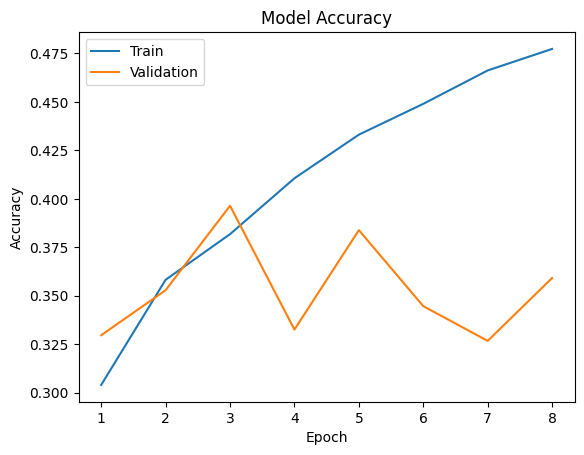

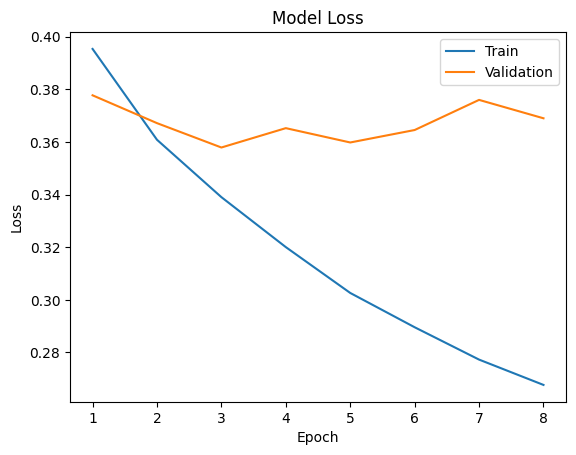

In [73]:
plotLearningCurve(history,8)